## Setup

In [1]:
from warnings import filterwarnings

import jax
from jax import vmap, jit
import jax.numpy as jnp
from jax.random import PRNGKey, split, normal
import jax.random as random
import numpy as np

import distrax
import tensorflow_probability.substrates.jax.distributions as tfd

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib inline
from functools import partial


cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)#
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

## Data

We create T=18 different versions of the "two moons" dataset, each rotated by a different amount. These correspond to T different binary classification "tasks" that we have to solve. 


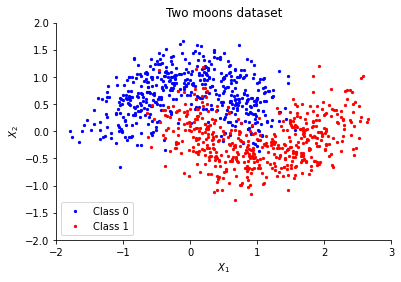

In [2]:
X, Y = make_moons(noise=0.3, n_samples=1000)

# latexify(width_scale_factor=2, fig_height=2.75)
# figsize = (15, 12)
# s = 20
# if is_latexify_enabled():
#     figsize = None
#     s = 5

plt.figure()
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], color="b", label="Class 0", s=5)
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1", s=5)
sns.despine()
plt.xlim(-2, 3)
plt.ylim(-2, 2)
plt.xlabel(r"$X_{1}$")
plt.ylabel(r"$X_{2}$")
plt.legend(loc="lower left")
plt.title("Two moons dataset")
# savefig("Two_moons_synthetic_dataset")
plt.show()

In [3]:
X.shape

(1000, 2)

In [4]:
n_groups = 18
# if is_latexify_enabled():
#     n_groups = 4

n_grps_sq = int(np.sqrt(n_groups))
n_samples = 100

In [5]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)

    return np.asarray(X)

In [6]:
np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)

    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.0
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

In [8]:
Xs = jnp.stack(Xs)
Ys = jnp.stack(Ys)

Xs_train = Xs[:, : n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2 :, :]
Ys_train = Ys[:, : n_samples // 2]
Ys_test = Ys[:, n_samples // 2 :]

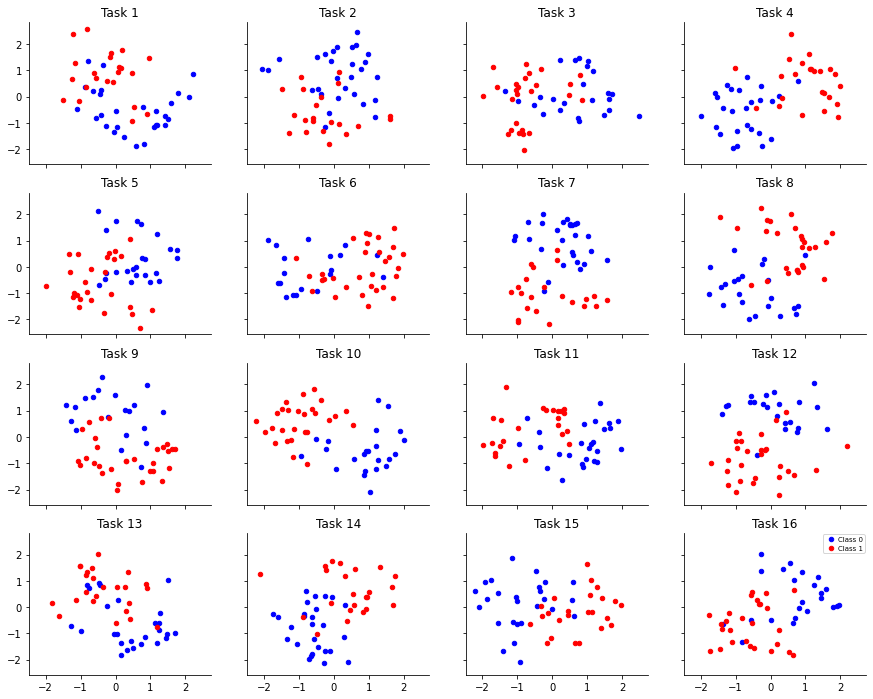

In [9]:
figsize = (15, 12)
s = 20
# if is_latexify_enabled():
#     figsize = None
#     s = 5
# latexify(width_scale_factor=2, fig_height=2.75)
fig, axs = plt.subplots(figsize=figsize, nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="b", s=s, label="Class 0")
    ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", s=s, label="Class 1")
    sns.despine()
    ax.set_title("Task {}".format(i + 1))
ax.legend(fontsize=7, borderaxespad=0.2, handletextpad=0, borderpad=0.2)
# savefig("Tasks", tight_layout=False, tight_bbox=False)

In [10]:
grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid_3d = jnp.repeat(grid[None, ...], n_groups, axis=0)

## Hierarchical Model (in Flax)

We repeat the same experiment from the last section, but we implement the MLP using Flax 

In [11]:
try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn

from jax.flatten_util import ravel_pytree

In [16]:
HalfNormal = distrax.as_distribution(tfd.HalfNormal(1.0))

In [12]:
key = jax.random.PRNGKey(0)
key_model_init, key_state_init, key_sample = jax.random.split(key, 3)

In [13]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.tanh(nn.Dense(5)(x))
        x = nn.tanh(nn.Dense(5)(x))
        x = nn.Dense(1)(x)
        #x = nn.log_sigmoid(x)
        return x


model = MLP()
batch = jnp.ones((n_samples, 2))

In [14]:
params=model.init(key_model_init,batch)

In [16]:
import optax 

def loss(params, batch,labels):
    logits = model.apply(params,batch)
    # optax also provides a number of common loss functions.
    loss_value = optax.sigmoid_binary_cross_entropy(logits.ravel(), labels).sum(axis=-1)
    return loss_value.mean()

In [17]:
def fit(params,optimizer,num_epochs=100):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, batch, labels):
        loss_value, grads = jax.value_and_grad(loss)(params, batch, labels)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    for i in range(num_epochs):
        for j, (batch, labels) in enumerate(zip(Xs_train, Ys_train)):
            params, opt_state, loss_value = step(params, opt_state, batch, labels)
        if i % (num_epochs//10) == 0:
            print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-3)
params = fit(params, optimizer,num_epochs=100)

step 0, loss: 33.091758728027344
step 10, loss: 33.379737854003906
step 20, loss: 33.528568267822266
step 30, loss: 33.612464904785156
step 40, loss: 33.657920837402344
step 50, loss: 33.678653717041016
step 60, loss: 33.683349609375
step 70, loss: 33.67765808105469
step 80, loss: 33.665374755859375
step 90, loss: 33.649166107177734


In [22]:
def get_dataloader(X,y,batch_size,key):
    num_train=X.shape[0]
    indices = jnp.array(list(range(0,num_train)))
    indices=jax.random.permutation(key,indices)
    for i in range(0, len(indices),batch_size):
        batch_indices = jnp.array(indices[i: i+batch_size])
        yield X[batch_indices], y[batch_indices]

In [18]:
from jax import random 

# 2. Python loop with Jax kernel
@partial(jit, static_argnums=(2,3,6))
def sgld_kernel(key, param, grad_log_post, dt, X, y_data, minibatch_size):
    N, _ = X.shape
    key, subkey1, subkey2 = random.split(key, 3)
    idx_batch = random.choice(subkey1, N, shape=(minibatch_size,))
    grads = grad_log_post(param, X[idx_batch], y_data[idx_batch])
    noise=jax.tree_map(lambda p: random.normal(key=subkey2,shape=p.shape), param)
    param=jax.tree_map(lambda p, g,n: p+dt*g+jnp.sqrt(2*dt) * n, param, grads,noise)
    return key, param


def sgld_sampler_jax_kernel(key,log_post, grad_log_post, num_samples, dt, x_0, X, y_data, minibatch_size):
    samples = list()
    loss=list()
    param = x_0
    for i in range(num_samples):
        key, param = sgld_kernel(key, param, grad_log_post, dt, X, y_data, minibatch_size)
        loss.append(log_post(param,X,y_data))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {}, loss {}'.format(i,loss[-1]))
    return samples,loss

@partial(jit, static_argnums=(1,2,3,8))
def sgld_sampler_full_jax(key,log_post, grad_log_post, num_samples, dt, x_0, X, y_data, minibatch_size):

    def sgld_step(carry, x):
        key, param = carry
        key, (param,loss) = sgld_kernel(key, param, grad_log_post, dt, X, y_data, minibatch_size)
        return (key, param), (param,loss)

    carry = (key, x_0)
    _, samples = jax.lax.scan(sgld_step, carry, None, num_samples)
    return samples

In [19]:
def log_likelihood(params,batch,labels):
    logits=model.apply(params,batch)
    log_p=jax.nn.log_sigmoid(logits)
    log_not_p = jax.nn.log_sigmoid(-logits)
    return -jnp.sum(labels*log_p+(1.-labels)*log_not_p)

def log_prior(params):
    return 1.
    #squared_params=jax.tree_map(lambda p: jnp.sum(p*p), params)
    #return jnp.sum(jnp.stack(jax.tree_util.tree_leaves(squared_params['params'])))

def log_post(params,batch,labels):
    n_data=batch.shape[0]
    return log_prior(params) + log_likelihood(params,batch,labels)

grad_log_post=jax.jit(jax.grad(log_post))

In [20]:
key=random.PRNGKey(32)
samples,loss=sgld_sampler_jax_kernel(key,log_likelihood,grad_log_post,1_000,1e-2,params,Xs_train[0,:,:],Ys_train[0,:],10)

iteration 0, loss 1847.4912109375
iteration 100, loss 438948.6875
iteration 200, loss 871084.125
iteration 300, loss 1377134.5
iteration 400, loss 1843314.75
iteration 500, loss 2290853.0
iteration 600, loss 2780776.75
iteration 700, loss 3248847.25
iteration 800, loss 3722872.5
iteration 900, loss 4184676.25


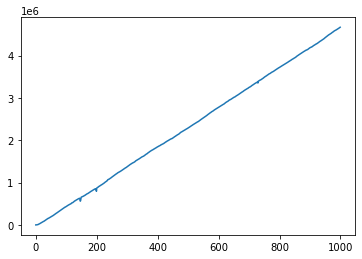

In [21]:
plt.plot(jnp.stack(loss))

In [22]:
Y_pred=jax.nn.sigmoid(model.apply(samples[-1],Xs_train[0,:,:]))>0.5
print("Train accuracy = {:.2f}%".format(100 * jnp.mean(jnp.squeeze(Y_pred) == Ys_train[0,:])))

Train accuracy = 44.00%
